In [13]:
# Setup environment
# !apt-get -qq install xxd
# !pip3 install pandas numpy matplotlib
# !pip3 install tensorflow==2.13.0


1481.77s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


You should consider upgrading via the '/Users/jianchundai/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


1488.46s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


You should consider upgrading via the '/Users/jianchundai/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


/var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/ipykernel_2851/570664732.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')


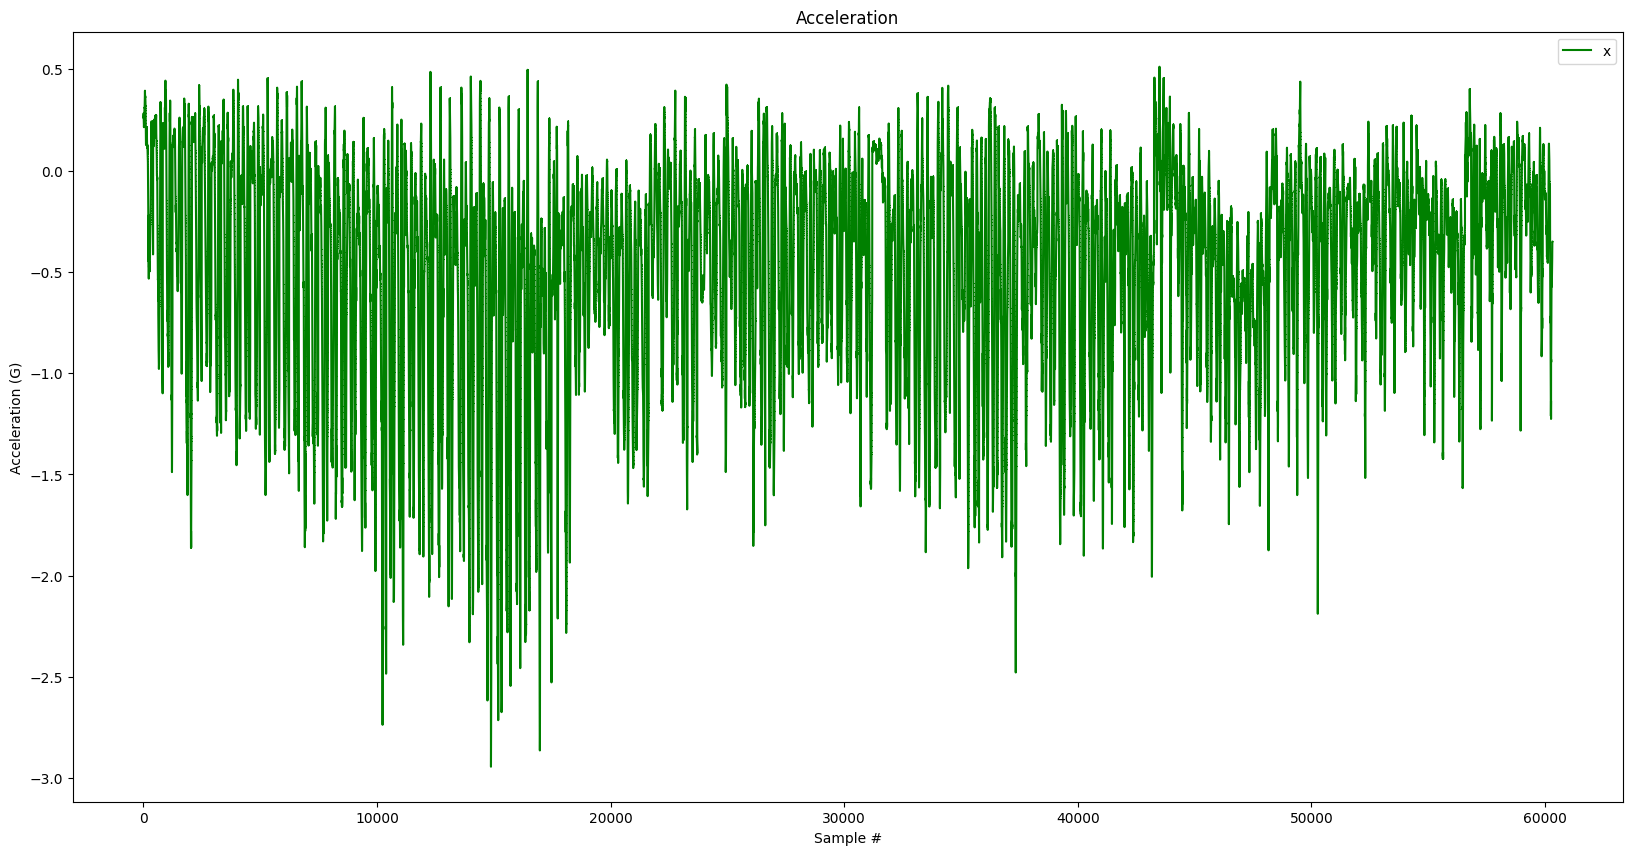

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

filename = "a.csv"

df = pd.read_csv("./content/" + filename)

index = range(1, len(df['aX']) + 1)

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(index, df['aX'], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['aY'], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['aZ'], 'r.', label='z', linestyle='solid', marker=',')
plt.title("Acceleration")
plt.xlabel("Sample #")
plt.ylabel("Acceleration (G)")
plt.legend()
plt.show()

# plt.plot(index, df['gX'], 'g.', label='x', linestyle='solid', marker=',')
# plt.plot(index, df['gY'], 'b.', label='y', linestyle='solid', marker=',')
# plt.plot(index, df['gZ'], 'r.', label='z', linestyle='solid', marker=',')
# plt.title("Gyroscope")
# plt.xlabel("Sample #")
# plt.ylabel("Gyroscope (deg/sec)")
# plt.legend()
# plt.show()


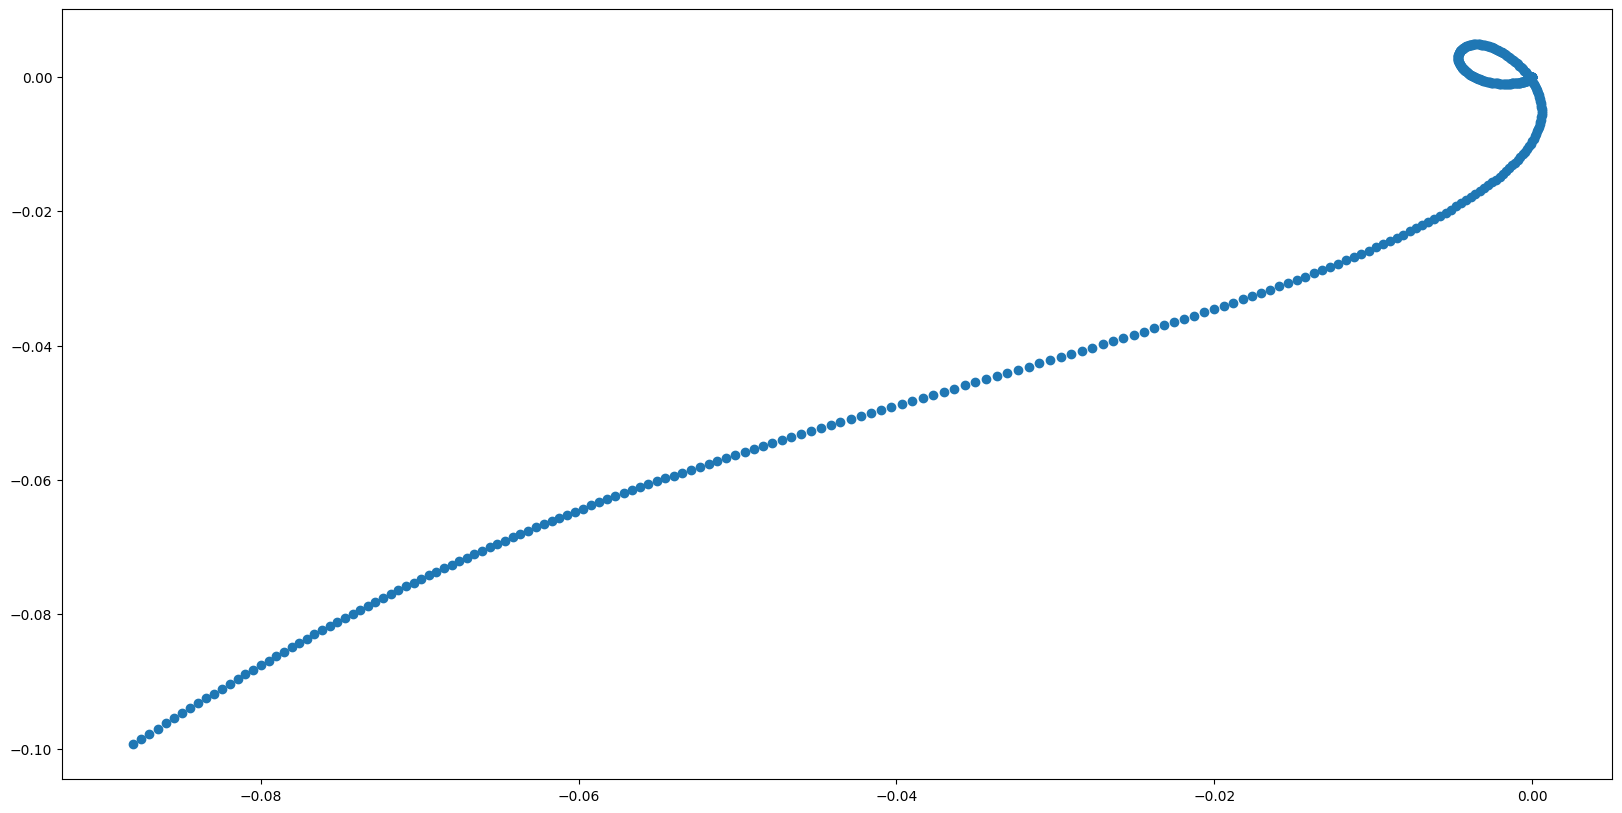

In [15]:
plt.scatter(dy_list, dz_list)
plt.show()

In [16]:
df.shape

(60320, 6)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "a",
    "b",
]

SAMPLES_PER_GESTURE = 416

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
  gesture = GESTURES[gesture_index]
  print(f"Processing index {gesture_index} for gesture '{gesture}'.")
  
  output = ONE_HOT_ENCODED_GESTURES[gesture_index]
  
  df = pd.read_csv("./content/" + gesture + ".csv")
  
  # calculate the number of gesture recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)
  
  print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")
  
  for i in range(num_recordings):
    tensor = []
    for j in range(SAMPLES_PER_GESTURE // 2 + 100):
      index = i * SAMPLES_PER_GESTURE + j
      # normalize the input data, between 0 to 1:
      # - acceleration is between: -4 to +4
      # - gyroscope is between: -2000 to +2000
      tensor += [
          (df['aX'][index] + 4) / 8,
          (df['aY'][index] + 4) / 8,
          (df['aZ'][index] + 4) / 8,
          (df['gX'][index] + 2000) / 4000,
          (df['gY'][index] + 2000) / 4000,
          (df['gZ'][index] + 2000) / 4000
      ]

    inputs.append(tensor)
    outputs.append(output)
    inputs.append(tensor)
    outputs.append(output)
# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

2023-09-23 08:49:28.297211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version = 2.13.0

Processing index 0 for gesture 'a'.
	There are 145 recordings of the a gesture.
Processing index 1 for gesture 'b'.
	There are 145 recordings of the b gesture.
Data set parsing and preparation complete.


In [18]:
inputs.shape

(580, 1848)

In [19]:
outputs.shape

(580, 2)

In [20]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [21]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=10, batch_size=1, validation_data=(inputs_validate, outputs_validate))



Epoch 1/10
348/348 [==============================] - 2s 4ms/step - loss: 0.3084 - mae: 0.5086 - val_loss: 0.2505 - val_mae: 0.5005
Epoch 2/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2503 - mae: 0.5003 - val_loss: 0.2498 - val_mae: 0.4998
Epoch 3/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2499 - mae: 0.4999 - val_loss: 0.2494 - val_mae: 0.4993
Epoch 4/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2497 - mae: 0.4996 - val_loss: 0.2492 - val_mae: 0.4989
Epoch 5/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2496 - mae: 0.4994 - val_loss: 0.2490 - val_mae: 0.4986
Epoch 6/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2496 - mae: 0.4993 - val_loss: 0.2489 - val_mae: 0.4984
Epoch 7/10
348/348 [==============================] - 1s 3ms/step - loss: 0.2495 - mae: 0.4991 - val_loss: 0.2489 - val_mae: 0.4982
Epoch 8/10
348/348 [==============================] - 1s 3ms/step - loss: 0.

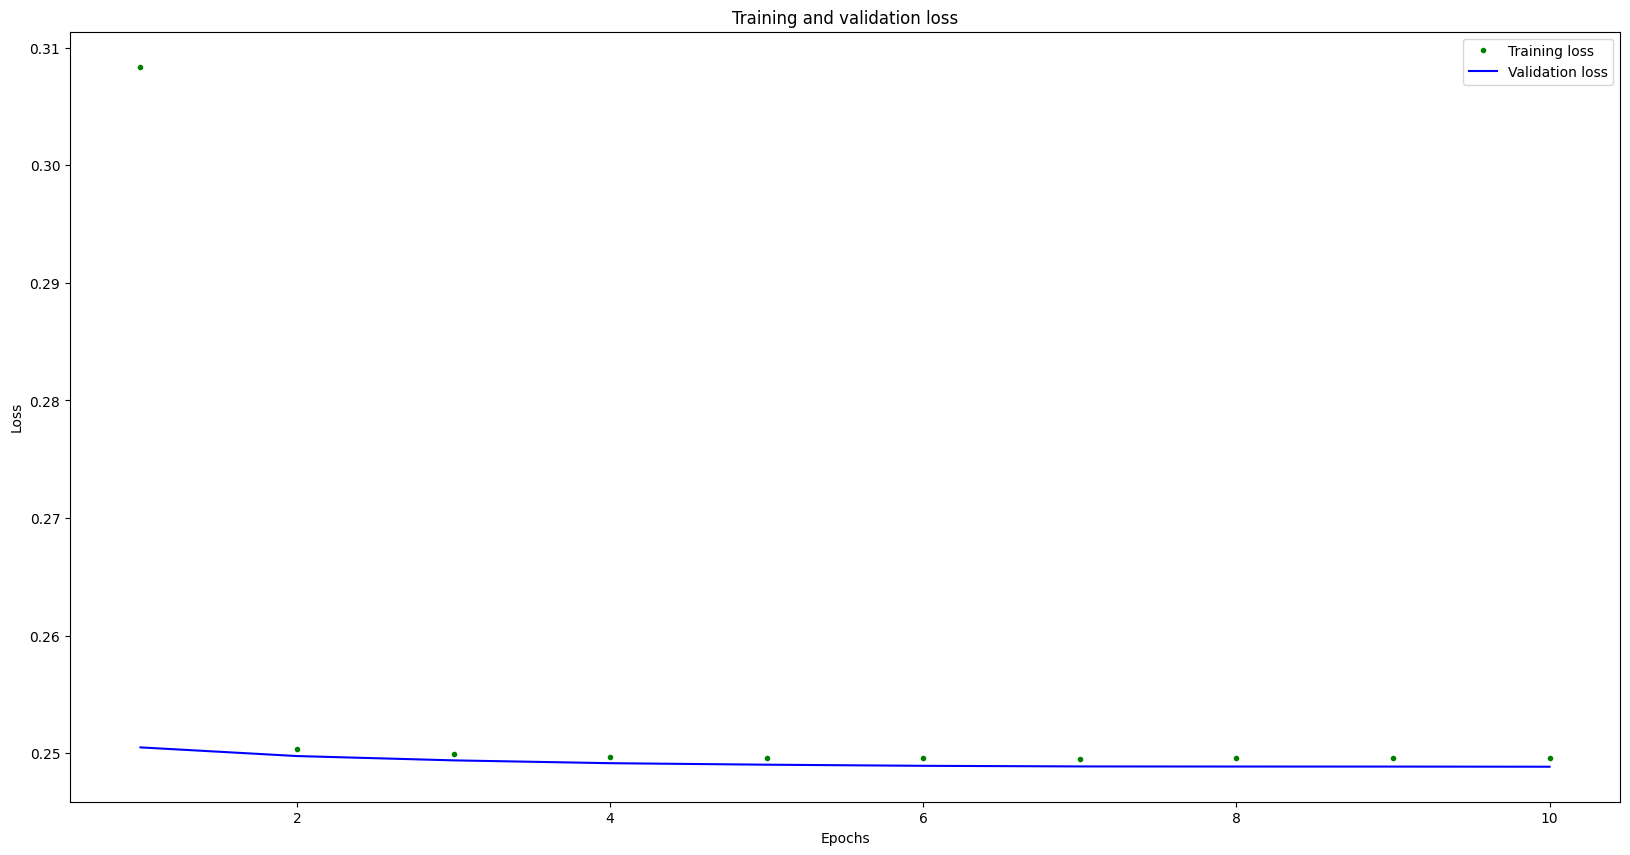

[20.0, 10.0]


In [22]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

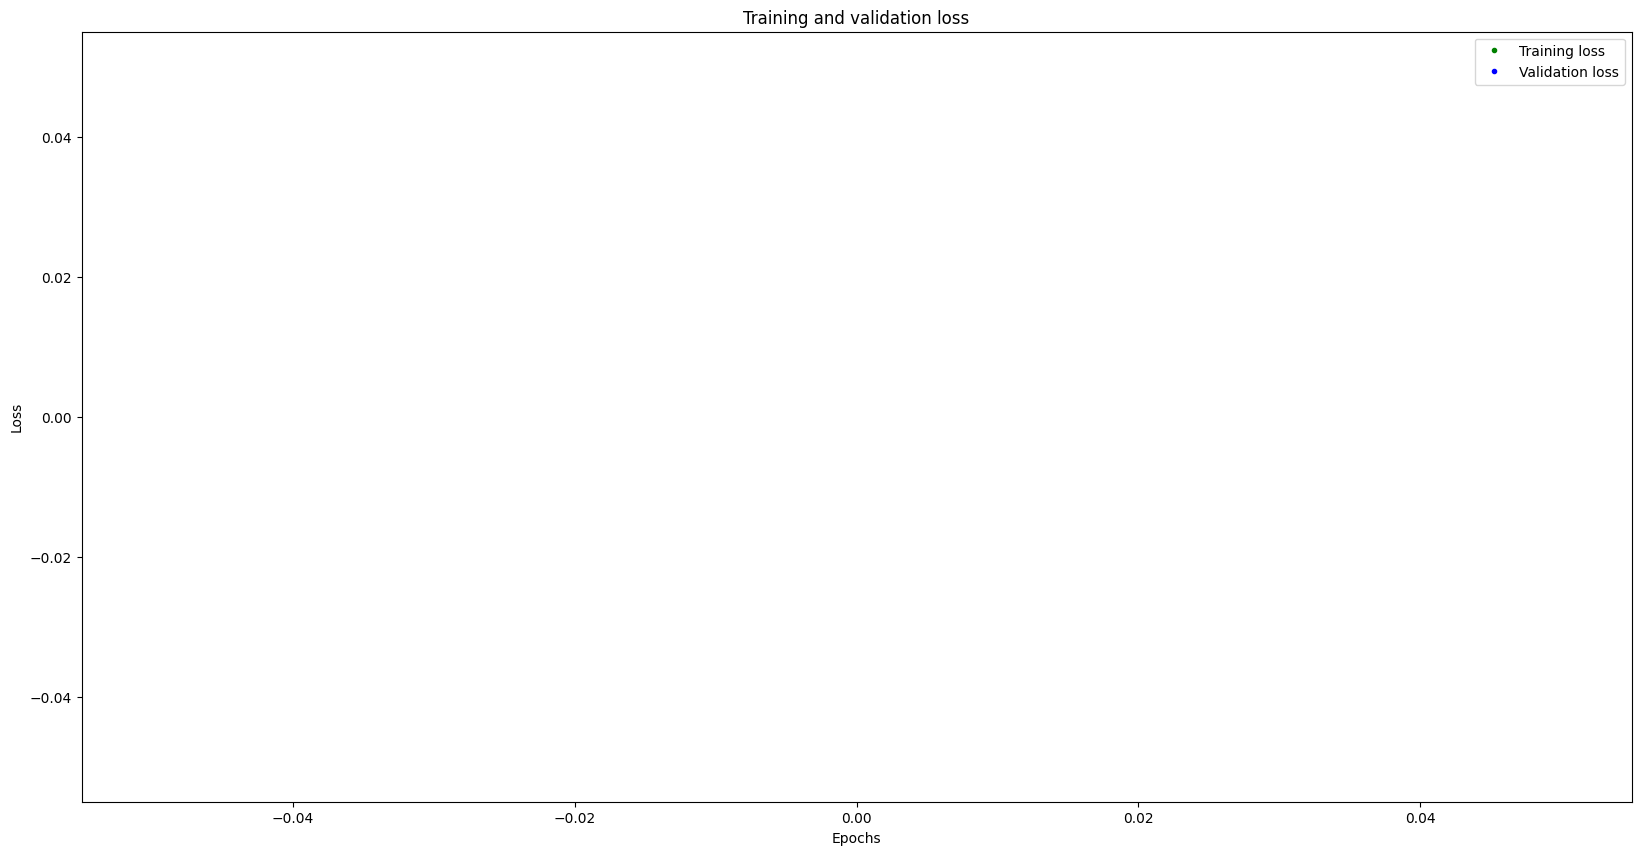

In [23]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

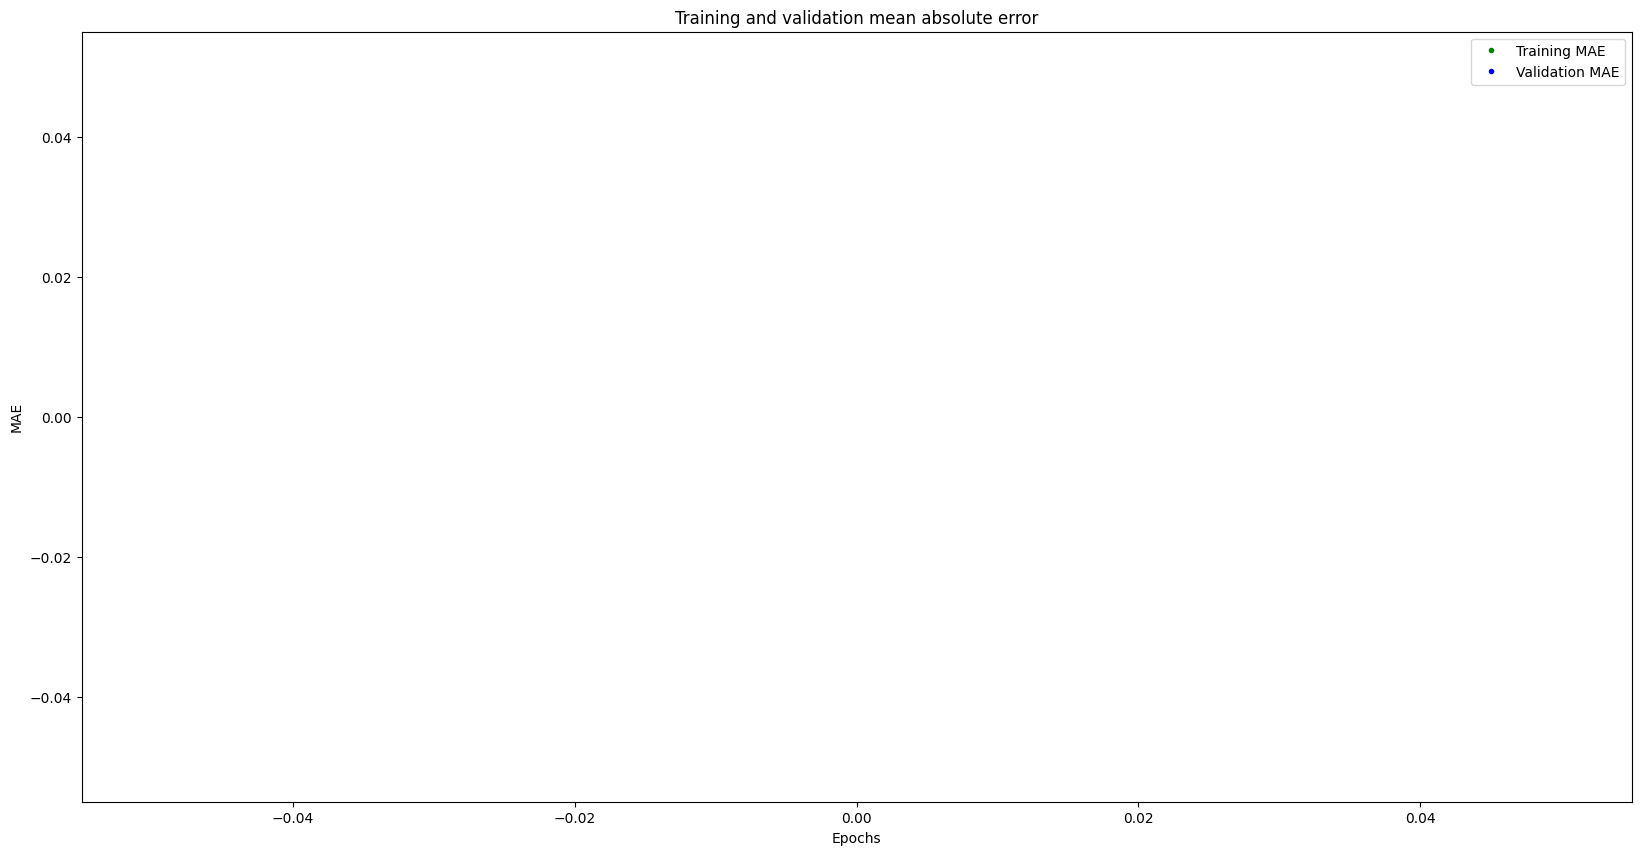

In [24]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [25]:
print(inputs_test.shape)
print(outputs_test.shape)

(116, 1848)
(116, 2)


In [26]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)
# predictions = model.predict(inputs_test[0].reshape(1,1248))
# print(predictions[0])
# print(outputs_test[0])
# print (inputs_test[0])

# pd.DataFrame(inputs_test[0]).to_csv("test1.h", sep=',', encoding='utf-8', index=False, header=False)
# !echo "const unsigned char tt[] = {" > ./tt.h
# !cat "test1.csv" | xxd -i      >> ./tt.h
# !echo "};"                              >> ./tt.h

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
# print("actual =\n", outputs_test)
a = np.round(predictions - outputs_test, decimals=0)
print(a)
# Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

4/4 [==============================] - 0s 2ms/step
predictions =
 [[0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.473 0.527]
 [0.

In [27]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmps_9joucl/assets


INFO:tensorflow:Assets written to: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmps_9joucl/assets


Model is 375080 bytes


2023-09-23 08:50:09.137258: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-23 08:50:09.137278: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-23 08:50:09.138060: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmps_9joucl
2023-09-23 08:50:09.139165: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2023-09-23 08:50:09.139181: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /var/folders/37/t8fhr8j953xfnbs16xcvwq3w0000gn/T/tmps_9joucl
2023-09-23 08:50:09.141983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2023-09-23 08:50:09.143307: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-23 08:50:09.195367: I tensorflow/cc/saved_model/loader.

In [28]:
!echo "const unsigned char model[] = {" > ./content/model.h
!cat gesture_model.tflite | xxd -i      >> ./content/model.h
!echo "};"                              >> ./content/model.h

import os
model_h_size = os.path.getsize("./content/model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

1546.00s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1551.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1556.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Header file, model.h, is 2,313,028 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
